In [6]:
!pip install dlib
!pip install mtcnn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 16.9 MB/s eta 0:00:00m eta 0:00:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 23.5 MB/s eta 0:00:00 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.1/309.1 KB 21.6 MB/s eta 0:00:00


In [ ]:
!pip install 

In [67]:
import cv2
import os
import numpy as np
#from google.colab.patches import cv2_imshow
import time
import os
from mtcnn.mtcnn import MTCNN
import matplotlib.pyplot as plt
import random
random.seed(99)

In [68]:
path0, = !echo $PWD
print(path0)
path0 = path0 + '/dist_comp_vision/ComputerVisionDQuispe/models/'
modelFile = f'{path0}/res10_300x300_ssd_iter_140000.caffemodel'
configFile = f'{path0}/deploy.prototxt'
mname = "DNN"
net = cv2.dnn.readNetFromCaffe(configFile, modelFile)
detector_mtcnn = MTCNN()

/home/aldo/maestria


In [69]:
# wider face dataset
# https://drive.google.com/file/d/1HIfDbVEWKmsYKJZm4lchTBDLW5N7dY5T/view

In [70]:
rootpath = "/home/aldo/maestria/dist_comp_vision/"#os.listdir("/home/aldo/maestria/dist_comp_vision/LFW/lfw-deepfunneled/lfw-deepfunneled/")

In [71]:
val_bbox_path = f"{rootpath}/WFD/wider_face_split/wider_face_split/wider_face_val_bbx_gt.txt"
val_images = f"{rootpath}/WFD/wider_val/WIDER_val/images/"


def parse_wider_annotations(annotation_file):
    """
    Returns structure: { 'image_name.jpg': [[x, y, w, h], [x, y, w, h], ...] }
    """
    wider_data = {}
    
    with open(annotation_file, 'r') as f:
        lines = f.readlines()
        
    i = 0
    while i < len(lines):
        filename = lines[i].strip() # filename
        i += 1
        
        try:
            num_faces = int(lines[i].strip()) # numer of faces
            i += 1
        except ValueError:
            
            break
            
        faces = []
        if num_faces == 0:
            # in case number of faces = 0 
            wider_data[filename] = []
            continue

        for _ in range(num_faces):
            # feature line: x1, y1, w, h, blur, expression, illumination, invalid, occlusion, pose
            # (x, y, w, h)
            line_data = lines[i].strip().split()
            x = int(line_data[0])
            y = int(line_data[1])
            w = int(line_data[2])
            h = int(line_data[3])
            
            # (x, y, w, h)
            faces.append([x, y, w, h])
            i += 1
            
        wider_data[filename] = faces
        
    return wider_data

In [72]:
img_bgr.shape

(694, 1024, 3)

In [73]:
print("Cargando etiquetas...")
ground_truth = parse_wider_annotations(val_bbox_path)

rnd_keys = list(ground_truth.keys())
random.shuffle(rnd_keys)
ground_truth = {k:ground_truth[k] for k in rnd_keys}

confidenceThreshold = 0.5
print(f"Etiquetas cargadas para {len(ground_truth)} imágenes.")

Cargando etiquetas...
Etiquetas cargadas para 3226 imágenes.


    DNN 1
    MTCNN 1
		 0.9822607636451721


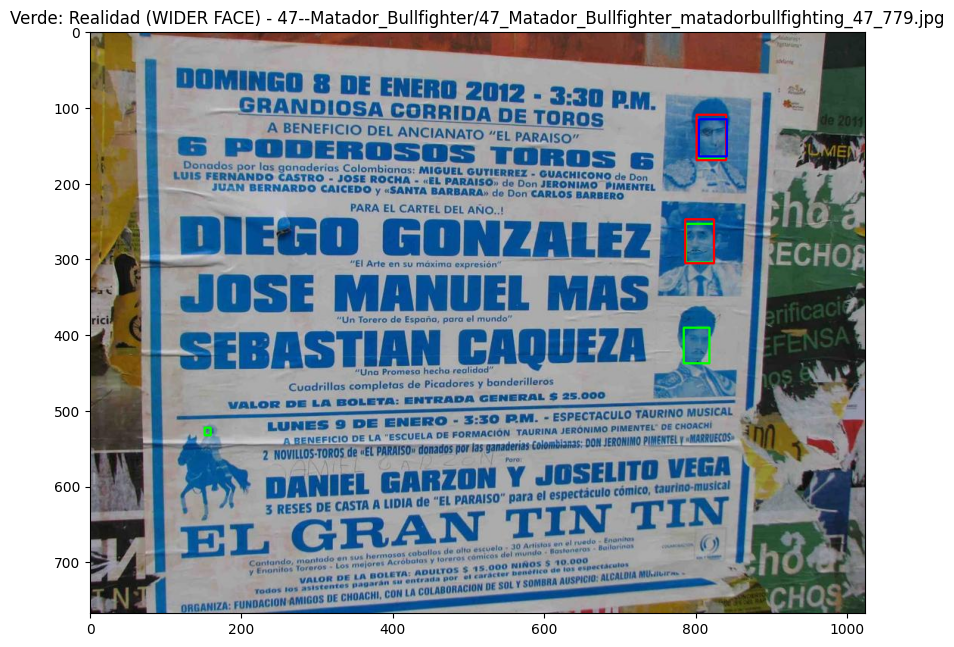

    DNN 1
    MTCNN 1
		 0.9998815059661865


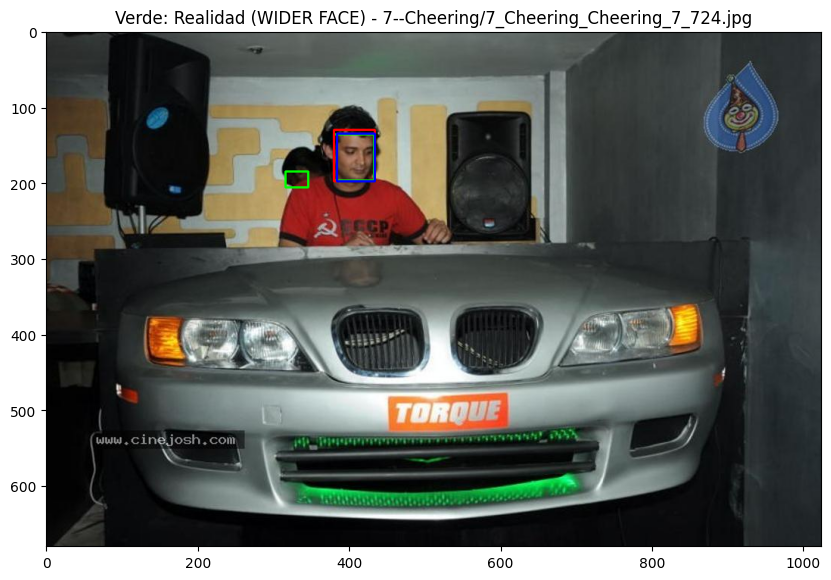

    DNN 1
    MTCNN 2
		 0.9968518614768982
		 0.9711928963661194


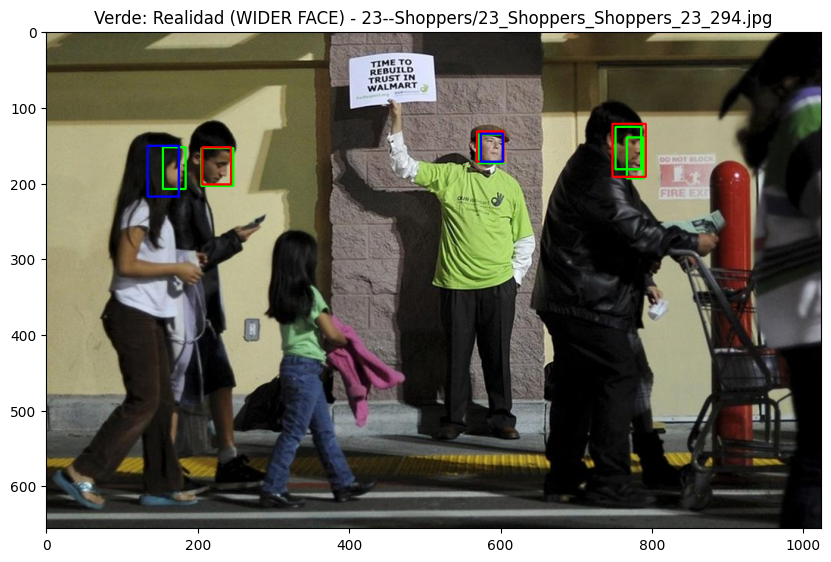

    DNN 1
    MTCNN 1
		 0.9933627843856812


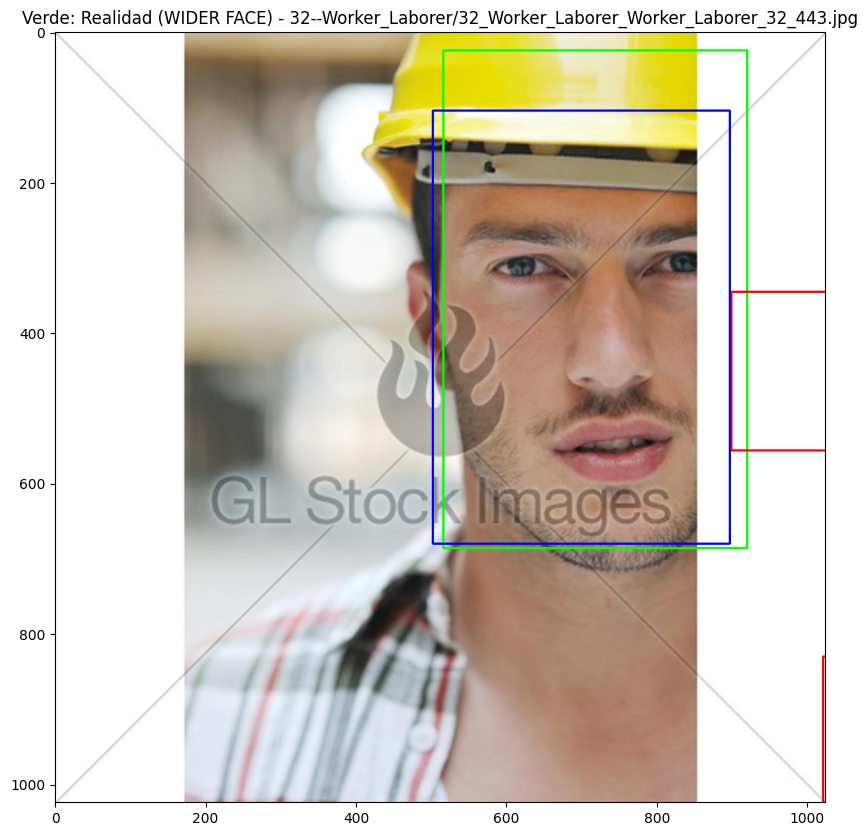

    DNN 1
    MTCNN 3
		 1.0
		 0.9999995231628418
		 0.9999642372131348


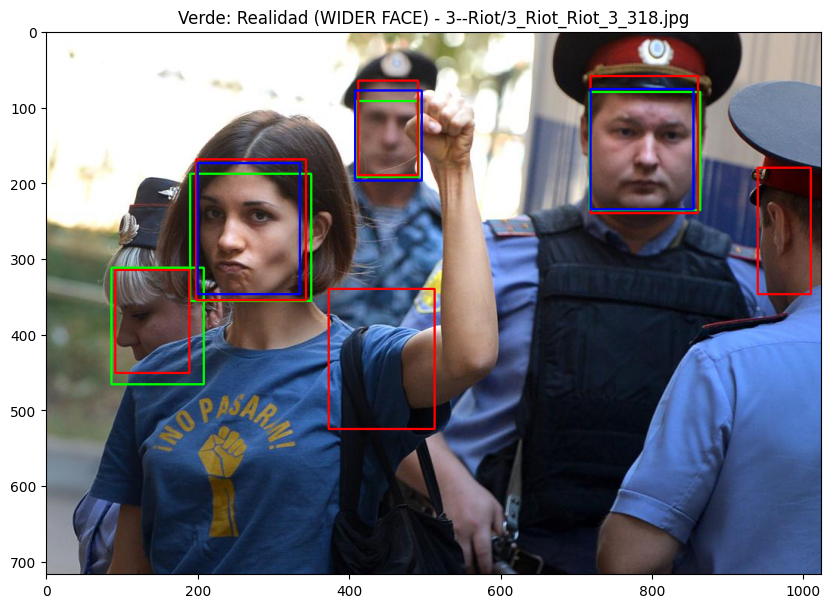

In [74]:
# iterate on images to test the model
count = 0
for img_path_rel, true_boxes in ground_truth.items():
    if count > 4: break # Solo probamos 3 para no saturar la salida
    
    full_path = os.path.join(val_images, img_path_rel)
    img_bgr = cv2.imread(full_path)
    img = img_bgr.copy()
    height_, width_ = img.shape[:2]
    if img_bgr is None:
        print(f"No se encontró: {full_path}")
        continue

    for box in true_boxes:
        x, y, w, h = box
        cv2.rectangle(img_bgr, (x, y), (x+w, y+h), (0, 255, 0), 2)
        
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    # --- applying models --- CNN & MTCNN
    # --- DNN
    
    #blob = cv2.dnn.blobFromImage(img_rgb, 1.0, (300,300), (104.0, 177.0, 123.0))
    blob = cv2.dnn.blobFromImage(img, 1.0, (width_, height_), (104.0, 117.0, 123.0), False, False)
    net.setInput(blob)
    detections = net.forward()
    print("    DNN", len(detections))
    detected_faces_count = 0
    for i in range(detections.shape[2]):
      confidence = detections[0, 0, i, 2] ## el tercer indice es el valor de confianza

      if confidence > confidenceThreshold:
        detected_faces_count += 1
        #counts += 1
        box_normalized = detections[0,0,i,3:7]
        box = box_normalized * np.array([width_, height_, width_, height_])
        (x, y, x1, y1) = box.astype('int')

        ## DIBUJA EL RECTANGULO
        cv2.rectangle(img_bgr, (x, y), (x1, y1), (0, 0, 255), 2)

    # --- MTCNN
    #img_rgb = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)
    result =  detector_mtcnn.detect_faces(img_rgb)
    print("    MTCNN", len(result))
    rectangles = []
    

    for face in result:
        confianza = face['confidence']
        print("\t\t", confianza)
        # filter by confidence
        if confianza > 0.50: 
            x, y, width, height = face['box']
            
            # avoid negative coord.
            x = max(0, x)
            y = max(0, y)
            x1 = x + width
            y1 = y + height
            cv2.rectangle(img_bgr, (x, y), (x1, y1), (255, 0, 0), 2)
            rectangles.append((x, y, x1, y1))
    
    plt.figure(figsize=(10,10))
    plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
    plt.title(f"Verde: Realidad (WIDER FACE) - {img_path_rel}")
    plt.show()
    
    count += 1

In [75]:

def bb_intersection_over_union(boxA, boxB):
    # overlapping area coordenates
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # overlapping area
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    # detected areas
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

    # Intersection over union
    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

def calculate_image_stats(pred_boxes, gt_boxes, iou_thresh=0.5):
    """
    for a single image
    Compares and returns : True Positives, False Positives, False Negatives
    """
    tp = 0
    fp = 0
    fn = 0


    gt_pendientes = list(gt_boxes) 
    preds_pendientes = list(pred_boxes)
    
    # greedy matcher
    for pred in preds_pendientes:
        best_iou = 0
        best_gt_idx = -1
        
        for i, gt in enumerate(gt_pendientes):
            iou = bb_intersection_over_union(pred, gt)
            if iou > best_iou:
                best_iou = iou
                best_gt_idx = i
        
        # evaluat overlapping percent - > if true TP
        if best_iou >= iou_thresh:
            tp += 1
            # remove GT from list
            gt_pendientes.pop(best_gt_idx)
        else:
            # False Positive
            fp += 1
            
    # remanent GTare FN false negatives
    fn = len(gt_pendientes)
    
    return tp, fp, fn
    

In [83]:

CONF_THRESH_DNN = 0.5   # DNN confidence threshold
CONF_THRESH_MTCNN = 0.8 # Confidence threshold MTCNN
IOU_THRESH = 0.3      # overlapping threshold

# counter
stats = {
    'DNN':   {'TP': 0, 'FP': 0, 'FN': 0, 'TotalTime':.0},
    'MTCNN': {'TP': 0, 'FP': 0, 'FN': 0, 'TotalTime':.0}
}

print("Iniciando evaluación... ")

count = 0
limit = 50 # limiten number of images / None: allows all images

for img_path_rel, true_boxes_raw in ground_truth.items():
    if limit and count >= limit: break
    count += 1
    #if count % 10 == 0: 
    #print(f"Procesando imagen {count}...", end="\r")
    full_path = os.path.join(val_images, img_path_rel)
    img_bgr = cv2.imread(full_path)
    if img_bgr is None: continue
    
    height_, width_ = img_bgr.shape[:2]
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    # Convertir Ground Truth a formato [x1, y1, x2, y2] para facilitar IoU
    gt_boxes = []
    for box in true_boxes_raw:
        x, y, w, h = box
        gt_boxes.append([x, y, x + w, y + h])

    blob = cv2.dnn.blobFromImage(img_bgr, 1.0, (width_, height_), (104.0, 117.0, 123.0), False, False)
    net.setInput(blob)
    
    # --- DNN
    start_time = time.perf_counter() # Inicio cronómetro preciso
    detections = net.forward()
    end_time = time.perf_counter()   # Fin cronómetro
    
    stats['DNN']['TotalTime'] += (end_time - start_time) # Acumulamos la diferencia
    
    dnn_boxes = []
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > CONF_THRESH_DNN:
            box = detections[0, 0, i, 3:7] * np.array([width_, height_, width_, height_])
            (x1, y1, x2, y2) = box.astype("int")
            x1, y1 = max(0, x1), max(0, y1)
            x2, y2 = min(width_, x2), min(height_, y2)
            if x2 > x1 and y2 > y1:
                dnn_boxes.append([x1, y1, x2, y2])

    tp, fp, fn = calculate_image_stats(dnn_boxes, gt_boxes, IOU_THRESH)
    stats['DNN']['TP'] += tp
    stats['DNN']['FP'] += fp
    stats['DNN']['FN'] += fn


    # --- EVALUAR MTCNN (+ Tiempo)

    start_time = time.perf_counter()
    result = detector_mtcnn.detect_faces(img_rgb)
    end_time = time.perf_counter()
    
    stats['MTCNN']['TotalTime'] += (end_time - start_time)

    mtcnn_boxes = []
    for face in result:
        if face['confidence'] > CONF_THRESH_MTCNN:
            x, y, w, h = face['box']
            x1, y1 = max(0, x), max(0, y)
            x2, y2 = x1 + w, y1 + h
            mtcnn_boxes.append([x1, y1, x2, y2])

    tp, fp, fn = calculate_image_stats(mtcnn_boxes, gt_boxes, IOU_THRESH)
    stats['MTCNN']['TP'] += tp
    stats['MTCNN']['FP'] += fp
    stats['MTCNN']['FN'] += fn
print()
print("Evaluación completada.")

Iniciando evaluación... 
Procesando imagen 50...
Evaluación completada.


In [86]:
def print_report(nombre, datos, total_imagenes):
    tp = datos['TP']
    fp = datos['FP']
    fn = datos['FN']
    total_time = datos['TotalTime']
    
    # precision
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    # Time
    avg_time = total_time / total_imagenes if total_imagenes > 0 else 0
    fps = 1.0 / avg_time if avg_time > 0 else 0
    
    print('')
    print(f"=========================================")
    print(f" REPORT: {nombre}")
    print(f"=========================================")
    print(f"--- RENDIMIENTO ---")
    print(f" PRECISION:  {precision:.4f} (Calidad)")
    print(f" RECALL:     {recall:.4f} (Cobertura)")
    print(f" F1-SCORE:   {f1_score:.4f}")
    print(f" TP: {tp} | FP: {fp} | FN: {fn}")
    print(f"--- VELOCIDAD ---")
    print(f" Tiempo Total:   {total_time:.2f} seg")
    print(f" Latencia Prom:  {avg_time*1000:.1f} ms/img")
    print(f" FPS Estimados:  {fps:.2f} FPS")
    print(f"\n")


print(f"\nEvaluación finalizada sobre {count} imágenes.\n")



Evaluación finalizada sobre 50 imágenes.



In [92]:
print_report("OpenCV DNN", stats['DNN'], count)
print_report("MTCNN", stats['MTCNN'], count)



 REPORT: OpenCV DNN
--- RENDIMIENTO ---
 PRECISION:  0.8165 (Calidad)
 RECALL:     0.3342 (Cobertura)
 F1-SCORE:   0.4743
 TP: 129 | FP: 29 | FN: 257
--- VELOCIDAD ---
 Tiempo Total:   4.72 seg
 Latencia Prom:  94.5 ms/img
 FPS Estimados:  10.58 FPS



 REPORT: MTCNN
--- RENDIMIENTO ---
 PRECISION:  0.9270 (Calidad)
 RECALL:     0.4275 (Cobertura)
 F1-SCORE:   0.5851
 TP: 165 | FP: 13 | FN: 221
--- VELOCIDAD ---
 Tiempo Total:   22.53 seg
 Latencia Prom:  450.5 ms/img
 FPS Estimados:  2.22 FPS




In [94]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']


Generando Reportes Gráficos...


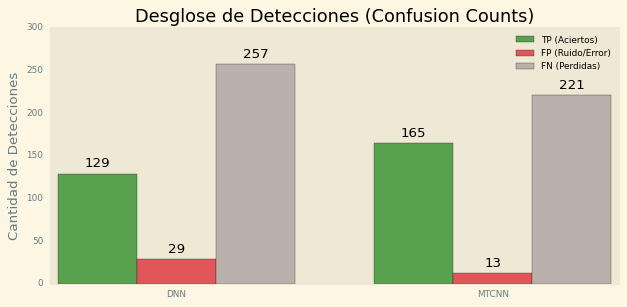

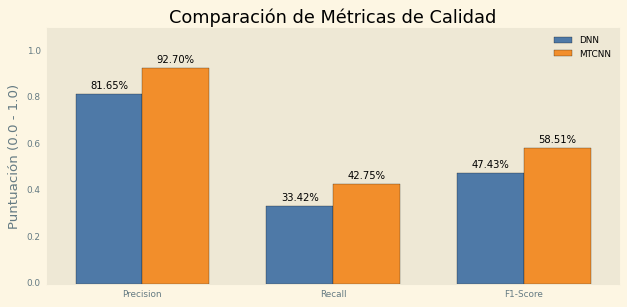

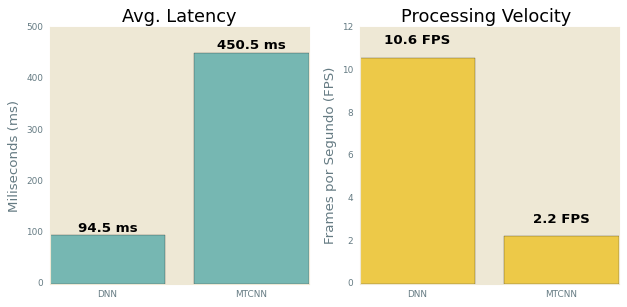

In [105]:
def graphic_report(stats, total_images):
    
    modelos = list(stats.keys()) # ['DNN', 'MTCNN']
    
    
    tp = [stats[m]['TP'] for m in modelos]
    fp = [stats[m]['FP'] for m in modelos]
    fn = [stats[m]['FN'] for m in modelos]
    times = [stats[m]['TotalTime'] for m in modelos]
    
    precision = []
    recall = []
    f1 = []
    fps = []
    latency = []

    for m in modelos:
        t, f_p, f_n = stats[m]['TP'], stats[m]['FP'], stats[m]['FN']
        total_time = stats[m]['TotalTime']
    
        p = t / (t + f_p) if (t + f_p) > 0 else 0
        r = t / (t + f_n) if (t + f_n) > 0 else 0
        f = 2 * (p * r) / (p + r) if (p + r) > 0 else 0
        
        precision.append(p)
        recall.append(r)
        f1.append(f)
    
        avg_time = total_time / total_images if total_images > 0 else 0
        latency.append(avg_time * 1000) # a ms
        fps.append(1.0 / avg_time if avg_time > 0 else 0)

    
    #plt.style.use('ggplot') 
    plt.style.use('tableau-colorblind10') #'seaborn-v0_8-colorblind')
    colores = ['#4E79A7', '#F28E2B'] 
    
    # confusion matrix
    fig1, ax1 = plt.subplots(figsize=(8, 4), facecolor="none")
    x = np.arange(len(modelos))
    width = 0.25
    
    rects1 = ax1.bar(x - width, tp, width, label='TP ', color='#59a14f') # Verde
    rects2 = ax1.bar(x, fp, width, label='FP (Error)', color='#e15759')      # Rojo
    rects3 = ax1.bar(x + width, fn, width, label='FN (Loss)', color='#bab0ac')  # Gris

    ax1.set_ylabel('Detecciones')
    ax1.set_title('Confusion Counts')
    ax1.set_xticks(x)
    ax1.set_xticklabels(modelos)
    ax1.legend()

    
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax1.annotate(f'{height}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)
    autolabel(rects3)
    plt.tight_layout()
    plt.show()

    # metrics
    fig2, ax2 = plt.subplots(figsize=(8, 4), facecolor="none")
    x = np.arange(3)  # Precision, Recall, F1
    width = 0.35
    
    # dnn data
    vals_m1 = [precision[0], recall[0], f1[0]]
    # MTCNN data
    vals_m2 = [precision[1], recall[1], f1[1]]

    rects1 = ax2.bar(x - width/2, vals_m1, width, label=modelos[0], color=colores[0])
    rects2 = ax2.bar(x + width/2, vals_m2, width, label=modelos[1], color=colores[1])

    ax2.set_ylabel('Value')
    ax2.set_title('Metrics')
    ax2.set_xticks(x)
    ax2.set_xticklabels(['Precision', 'Recall', 'F1-Score'])
    ax2.set_ylim(0, 1.1) 
    ax2.legend()

    def autolabel_percent(rects):
        for rect in rects:
            height = rect.get_height()
            ax2.annotate(f'{height:.2%}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=9)

    autolabel_percent(rects1)
    autolabel_percent(rects2)
    plt.tight_layout()
    plt.show()

    # time and velocity
    fig3, (ax3a, ax3b) = plt.subplots(1, 2, figsize=(8, 4), facecolor="none")
    #plt.figure(facecolor='yellow')
    
    # Subplot latency
    ax3a.bar(modelos, latency, color=['#76b7b2', '#76b7b2'])
    ax3a.set_title('Avg. Latency')
    ax3a.set_ylabel('Miliseconds (ms)')
    for i, v in enumerate(latency):
        ax3a.text(i, v + 1, f"{v:.1f} ms", ha='center', va='bottom', fontweight='bold')

    # Subplot FPS (Más es mejor)
    ax3b.bar(modelos, fps, color=['#edc948', '#edc948'])
    ax3b.set_title('Processing Velocity ')
    ax3b.set_ylabel('Frames por Segundo (FPS)')
    for i, v in enumerate(fps):
        ax3b.text(i, v + 0.5, f"{v:.1f} FPS", ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.show()

# --- LLAMADA FINAL ---
# Solo tienes que agregar esta línea al final de tu script anterior
# Asegúrate de pasar 'stats' y el contador 'count'
print("\nGenerando Reportes Gráficos...")
graphic_report(stats, count)

## by pixels or face size: 

Starting size-based analysis...
Processing image 20...
Processing image 40...
Processing image 60...
Processing image 80...
Processing image 100...
Evaluation completed.

--- RECALL BY FACE SIZE ---
[DNN]   Small (<50px): 16.30% (231/1417 detected)
[MTCNN] Small (<50px): 32.46% (460/1417 detected)
[DNN]   Medium (50-100px): 75.81% (94/124 detected)
[MTCNN] Medium (50-100px): 79.03% (98/124 detected)
[DNN]   Large (>100px): 77.78% (70/90 detected)
[MTCNN] Large (>100px): 81.11% (73/90 detected)


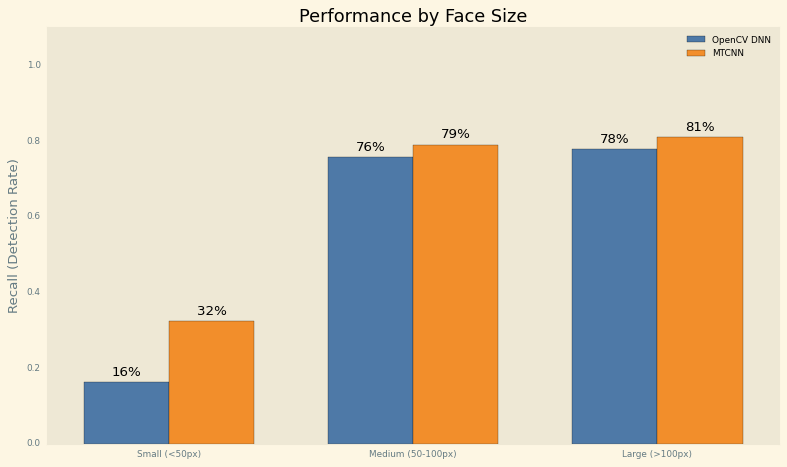

In [108]:
# Size categories (Height in pixels)
SIZE_RANGES = {
    'Small (<50px)': (0, 50),
    'Medium (50-100px)': (50, 100),
    'Large (>100px)': (100, 9999)
}

# metrics storage: stats[Model][Size][Metric]
stats_size = {
    'DNN':   {k: {'TP': 0, 'FN': 0} for k in SIZE_RANGES.keys()},
    'MTCNN': {k: {'TP': 0, 'FN': 0} for k in SIZE_RANGES.keys()}
}

def bb_iou_batch(boxA, boxesB):
    """
    Vectorized IoU calculation for one box against a list of boxes.
    """
    if len(boxesB) == 0: return []
    boxesB = np.array(boxesB)
    
    xA = np.maximum(boxA[0], boxesB[:, 0])
    yA = np.maximum(boxA[1], boxesB[:, 1])
    xB = np.minimum(boxA[2], boxesB[:, 2])
    yB = np.minimum(boxA[3], boxesB[:, 3])

    interArea = np.maximum(0, xB - xA + 1) * np.maximum(0, yB - yA + 1)
    
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxesB[:, 2] - boxesB[:, 0] + 1) * (boxesB[:, 3] - boxesB[:, 1] + 1)

    return interArea / (boxAArea + boxBArea - interArea)


def get_size_category(height):
    for name, (min_h, max_h) in SIZE_RANGES.items():
        if min_h <= height < max_h:
            return name
    return 'Large (>100px)'



print("Starting size-based analysis...")

count = 0
limit = 100 

for img_path_rel, true_boxes_raw in ground_truth.items():
    if limit and count >= limit: break
    count += 1
    if count % 20 == 0: print(f"Processing image {count}...")

    full_path = os.path.join(val_images, img_path_rel)
    img_bgr = cv2.imread(full_path)
    if img_bgr is None: continue
    
    h_img, w_img = img_bgr.shape[:2]
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    gt_boxes = []
    gt_heights = [] 
    for box in true_boxes_raw:
        x, y, w, h = box
        gt_boxes.append([x, y, x + w, y + h])
        gt_heights.append(h)

    # DNN Prediction
    blob = cv2.dnn.blobFromImage(img_bgr, 1.0, (w_img, h_img), (104.0, 117.0, 123.0), False, False)
    net.setInput(blob)
    detections = net.forward()
    
    dnn_preds = []
    for i in range(detections.shape[2]):
        if detections[0, 0, i, 2] > CONF_THRESH_DNN:
            box = detections[0, 0, i, 3:7] * np.array([w_img, h_img, w_img, h_img])
            dnn_preds.append(box.astype("int"))

    # MTCNN Prediction
    result = detector_mtcnn.detect_faces(img_rgb)
    mtcnn_preds = []
    for face in result:
        if face['confidence'] > CONF_THRESH_MTCNN:
            x, y, w, h = face['box']
            mtcnn_preds.append([x, y, x+w, y+h])

    # Size-based Matching
    def evaluate_model_by_size(model_name, preds, gts, heights):
        for i, gt in enumerate(gts):
            height = heights[i]
            category = get_size_category(height)
            
            max_iou = 0
            if len(preds) > 0:
                ious = bb_iou_batch(gt, preds)
                max_iou = np.max(ious) if len(ious) > 0 else 0
            
            if max_iou >= IOU_THRESH:
                stats_size[model_name][category]['TP'] += 1
            else:
                stats_size[model_name][category]['FN'] += 1

    evaluate_model_by_size('DNN', dnn_preds, gt_boxes, gt_heights)
    evaluate_model_by_size('MTCNN', mtcnn_preds, gt_boxes, gt_heights)

print("Evaluation completed.")


categories = list(SIZE_RANGES.keys())
recall_dnn = []
recall_mtcnn = []

print("\n--- RECALL BY FACE SIZE ---")
for cat in categories:
    # DNN Stats
    tp = stats_size['DNN'][cat]['TP']
    fn = stats_size['DNN'][cat]['FN']
    total = tp + fn
    rec = tp / total if total > 0 else 0
    recall_dnn.append(rec)
    print(f"[DNN]   {cat}: {rec:.2%} ({tp}/{total} detected)")

    # MTCNN Stats
    tp = stats_size['MTCNN'][cat]['TP']
    fn = stats_size['MTCNN'][cat]['FN']
    total = tp + fn
    rec = tp / total if total > 0 else 0
    recall_mtcnn.append(rec)
    print(f"[MTCNN] {cat}: {rec:.2%} ({tp}/{total} detected)")


x = np.arange(len(categories))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, recall_dnn, width, label='OpenCV DNN', color='#4E79A7')
rects2 = ax.bar(x + width/2, recall_mtcnn, width, label='MTCNN', color='#F28E2B')

ax.set_ylabel('Recall (Detection Rate)')
ax.set_title('Performance by Face Size')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.set_ylim(0, 1.1)
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.0%}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
plt.tight_layout()
plt.show()